In [1]:
%run tools.ipynb

In [2]:
# check flux updates

In [3]:
import numpy.random as nprd

In [4]:
%run bio_flux_functions_TransCom.ipynb

In [5]:
fig_dir = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/plots/'

In [6]:
#convert annual mean kg/m2/s to kg/month
#works for leap years
def unit_convert_monthly(dr, year, res_lat, res_lon):
    days_list = []
    for imonth in range(12): days_list.append(days_in_month(year, imonth+1))
    # use grid area function
    for imonth in range(12):
        for ilat, lat in enumerate(dr.lat.values):
            area = 1e6 * area_latlon(lat1 = lat, lat2 = lat + res_lat,
                                     lon1 = 10, lon2 = 10 + res_lon) # m^2, longitude doesn't matter
            dr[imonth, ilat, :] = dr[imonth, ilat, :] * area * days_list[imonth] * (3600*24) # kg/year
    dr.attrs['units'] = 'kg/month'
    return dr

In [7]:
input_dir = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/'

f1 = input_dir + 'NEE.Liang.2016.nc'
f2 = input_dir + 'Taka2009_CO2_Monthly.nc'
    
monthly_sink_before = regional_monthly_sink(f1, f2)
global_before = np.sum(monthly_sink_before, axis = 1) # global

f1 = input_dir + 'NEE.Liang.2016.updated.2017.Dec.nc'
f2 = input_dir + 'Taka2009_CO2_Monthly.updated.2017.Dec.nc'
    
monthly_sink_after = regional_monthly_sink(f1, f2)
global_after = np.sum(monthly_sink_after, axis = 1) # global


annual total of bio fluxes: -0.5014301513541818
after summing up monthly:  -0.5014273630952727
after regridding:  -0.5012923827665454
Total annual sink (PgC/year):  -1.8740684978229676
annual total of bio fluxes: 3.7585918838225454
after summing up monthly:  3.7586007490560003
after regridding:  3.7579269913134543
Total annual sink (PgC/year):  3.439319587717914


In [8]:
nx = 67
# all fluxes used in simulations
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/monthly_emission.nc'
ds_monthly = xr.open_dataset(fname)
dr_rest = ds_monthly['ff'] + ds_monthly['nte'] + ds_monthly['fire']

# use TransCom masks
fname = '/geos/u73/msadiq/GEOS-Chem/MASKS/MASK_TC67_1x1.nc'
ds_tc = xr.open_dataset(fname)
dr_mask = ds_tc['transcom_regions']
    
dr_flux_mask = dr_rest[0,:,:]
dr_flux_mask[:,:] = 0.
for ilon, lon in enumerate(dr_flux_mask['lon'].values):
    for ilat, lat in enumerate(dr_flux_mask['lat'].values):
        dr_flux_mask[ilat,ilon] = dr_mask.sel(lat = lat, lon = lon, method="nearest")

ds_mask_splits = split_mask(input_mask = dr_flux_mask)
ds_mask = ds_mask_splits.drop('MASK68')
    
# monthly regional total flux
monthly_flux_rest = np.zeros((12,nx))
    
for i in range(12):
    for j in range(nx):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_rest[i,:,:] * ds_mask[mask_name]
        monthly_flux_rest[i,j] = tmp.sum().values*1e-12*12/44 # unit: PgC/month
print('Total annual sink (PgC/year): ', np.sum(monthly_flux_rest))


Total annual sink (PgC/year):  5.831047179009186


In [9]:
monthly_regional_before = monthly_sink_before + monthly_flux_rest
monthly_regional_after  = monthly_sink_after  + monthly_flux_rest

#net_before = dr_net_monthly + global_before
#net_after = dr_net_monthly + global_after
net_before_monthly = np.sum(monthly_regional_before, axis = 1)
net_after_monthly  = np.sum(monthly_regional_after,  axis = 1)


In [10]:
# Liang's posterior
fname = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/liang/oco2_v9_2014_2018_monthly_flux.nc'
ds_liang = xr.open_dataset(fname)
varname  = 'flux'           # unit: kgC/m2/d
dr_2018  = ds_liang[varname][-36:-24,:,:]/(24*3600) # 2018 monthly, unit convert to kgC/m2/s
dr_2018_monthly_total = unit_convert_monthly(dr_2018, 2018, 4., 5.)
print('Liang 2018 global net flux (PgC/year):', dr_2018_monthly_total.sum().values*1e-12)

# use TransCom masks
fname = '/geos/u73/msadiq/GEOS-Chem/MASKS/MASK_TC67_1x1.nc'
ds_tc = xr.open_dataset(fname)
dr_mask = ds_tc['transcom_regions']
    
dr_flux_mask = dr_2018_monthly_total[0,:,:].copy()
dr_flux_mask[:,:] = 0.
for ilon, lon in enumerate(dr_flux_mask['lon'].values):
    for ilat, lat in enumerate(dr_flux_mask['lat'].values):
        dr_flux_mask[ilat,ilon] = dr_mask.sel(lat = lat, lon = lon, method="nearest")
        
ds_mask_splits = split_mask(input_mask = dr_flux_mask)
ds_mask = ds_mask_splits.drop('MASK68')
    
# monthly regional total flux
monthly_regional_liang = np.zeros((12,nx))
    
for i in range(12):
    for j in range(nx):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_2018_monthly_total[i,:,:] * ds_mask[mask_name]
        monthly_regional_liang[i,j] = tmp.sum().values*1e-12 # unit: PgC/month
print('Net flux after using masks (PgC/year): ', np.sum(monthly_regional_liang))

net_flux_liang = np.sum(monthly_regional_liang, axis = 1)


Liang 2018 global net flux (PgC/year): 5.196223241827417
Net flux after using masks (PgC/year):  5.196223241827417


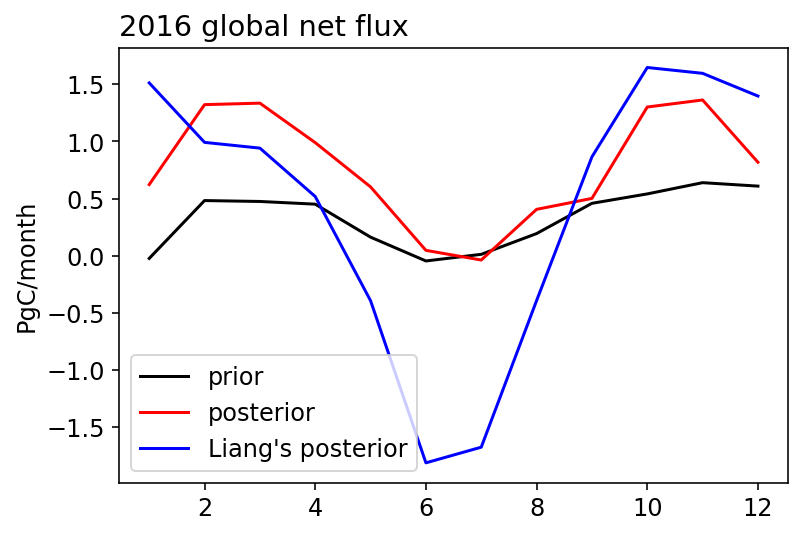

In [11]:
fig, ax = plt.subplots()
# prior
ax.plot(range(1,13), net_before_monthly, label = 'prior', color = 'black')
ax.plot(range(1,13), net_after_monthly, label = 'posterior', color = 'red')
ax.plot(range(1,13), net_flux_liang, label = "Liang's posterior", color = 'blue')
plt.title('2016 global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()

fig.savefig(fig_dir + 'global_net.png', dpi = 300)


In [12]:

nm_months = 33 # number of months finished inversion
sinks_monthly_inversion = np.zeros((nm_months,nx))
net_monthly_inversion = np.zeros((nm_months,nx))

for i in range(3, nm_months + 3):
    iyear = math.ceil(i/12) + 2015
    imonth = i - (iyear-2016)*12
    month_string = short_name_of_month(imonth)
    year_month_string = str(iyear) + '.' + month_string
    print(year_month_string)
    
    f1 = input_dir + 'NEE.Liang.2016.updated.' + year_month_string + '.nc'
    f2 = input_dir + 'Taka2009_CO2_Monthly.updated.' + year_month_string + '.nc'
    #print(f1,f2)
    monthly_sink = regional_monthly_sink(f1, f2)
    
    #sink_of_the_month = np.sum(monthly_sink[imonth-3,:])
    sinks_monthly_inversion[i-3,:] = monthly_sink[imonth-3,:]
    net_monthly_inversion[i-3,:] = monthly_sink[imonth-3,:] + monthly_flux_rest[imonth-3,:]
    #global_after = np.sum(monthly_sink, axis = 1) # global



2016.Mar
annual total of bio fluxes: -1.005600446277818
after summing up monthly:  -1.0056020191418182
after regridding:  -1.005436510952727
Total annual sink (PgC/year):  -2.975463906599294
2016.Apr
annual total of bio fluxes: -1.0532492172567272
after summing up monthly:  -1.05325264896
after regridding:  -1.0530921453381819
Total annual sink (PgC/year):  -3.1463607632293855
2016.May
annual total of bio fluxes: -1.1694461896145454
after summing up monthly:  -1.1694514086632728
after regridding:  -1.169260019712
Total annual sink (PgC/year):  -3.433408684258112
2016.Jun
annual total of bio fluxes: -1.6651665229265455
after summing up monthly:  -1.6651728143825453
after regridding:  -1.6648582415825453
Total annual sink (PgC/year):  -4.251463206097677
2016.Jul
annual total of bio fluxes: -2.8365855844538177
after summing up monthly:  -2.8365824387258183
after regridding:  -2.835192884875636
Total annual sink (PgC/year):  -5.69005849664101
2016.Aug
annual total of bio fluxes: -3.5194962

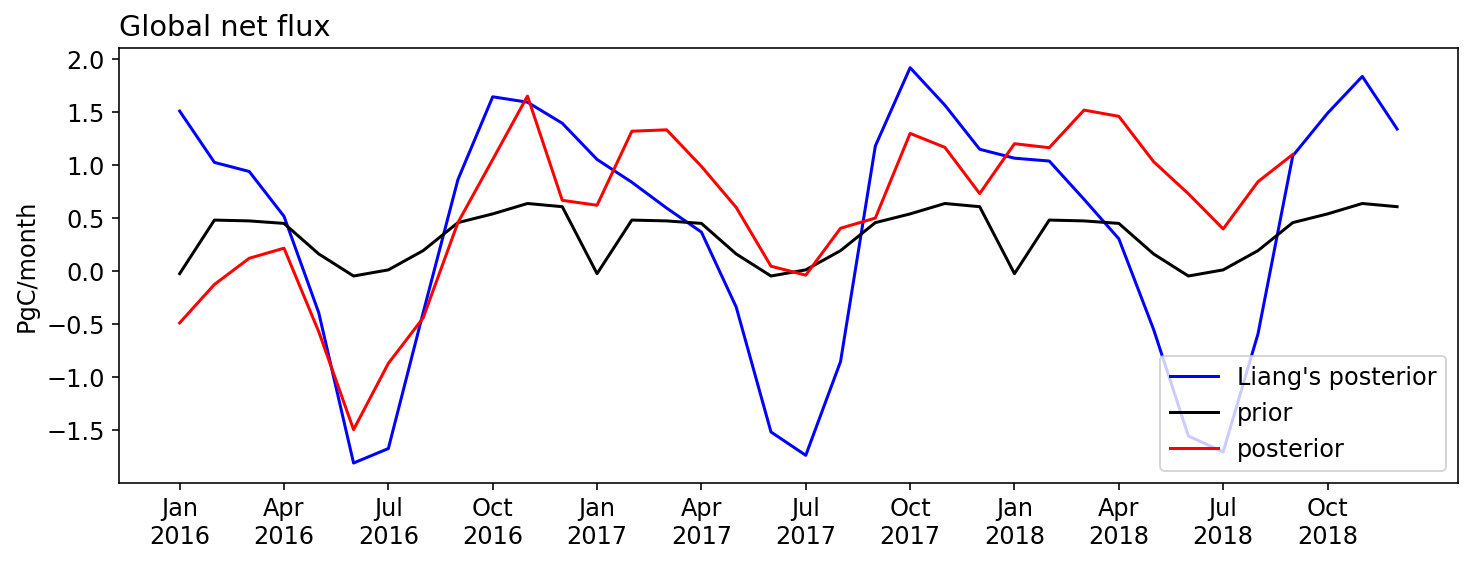

In [13]:
# plot multiple years global net flux
nm_years = 3
first_year = 2016
monthly_net_flux_years = np.zeros(nm_years*12)

#scale_factor_2016 = 1+(nprd.random_sample(12)-0.5)/3
#scale_factor_2017 = 1+(nprd.random_sample(12)-0.5)/3

monthly_net_flux_before = np.tile(net_before_monthly,nm_years)
#monthly_net_flux_after = np.tile(net_after_monthly,nm_years)
monthly_net_flux_after = np.sum(net_monthly_inversion, axis = 1)


# Liang's posterior
fname = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/liang/oco2_v9_2014_2018_monthly_flux.nc'
ds_liang = xr.open_dataset(fname)
varname  = 'flux'           # unit: kgC/m2/d
dr_3years = ds_liang[varname][-nm_years*12:,:,:]/(24*3600) # last 3 years, 2016-2018

for i in range(3):
    dr_monthly_total = unit_convert2_dr_monthly(dr_3years[i*12:(i+1)*12,:,:], 2016+i, 4., 5.)
    net_flux_monthly = np.sum(dr_monthly_total, axis = (1,2))*1e-12
    monthly_net_flux_years[i*12:(i+1)*12] = net_flux_monthly

fig, ax = plt.subplots(figsize=[12, 4])
# prior
ax.plot(range(1,nm_years*12+1), monthly_net_flux_years, label = "Liang's posterior", color = 'blue')

ax.plot(range(1,nm_years*12+1), monthly_net_flux_before, label = 'prior', color = 'black')
#ax.plot(range(1,nm_years*12+1), monthly_net_flux_after, label = 'posterior', color = 'red')
ax.plot(range(1,nm_months+1), monthly_net_flux_after, label = 'posterior', color = 'red')

plt.title('Global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()

ticks = []
for iyear in range(nm_years):
    for imonth in range(1,13,3):
        ticks.append(short_name_of_month(imonth) + '\n' + str(iyear+first_year))
plt.xticks(range(1,nm_years*12+1,3), ticks)

fig.savefig(fig_dir + 'inversion_3years.png', dpi = 300)


In [27]:
np.shape(net_monthly_inversion)
np.shape(monthly_regional_after)
np.shape(monthly_net_flux_years)

(36,)

In [25]:
#monthly_regional_before
TC_monthly_67_before = np.zeros((36,nx)) # 3 years, 23 transcom regions
TC_monthly_67_after = np.zeros((36,nx)) # 23 transcom regions
TC_monthly_67_liang = np.zeros((36,nx)) # 23 transcom regions

TC_monthly_67_before = 

TC_monthly_regional_before = np.zeros((36,23)) # 3 years, 23 transcom regions
TC_monthly_regional_after = np.zeros((36,23)) # 23 transcom regions
TC_monthly_regional_liang = np.zeros((36,23)) # 23 transcom regions


#monthly_regional_liang
TC_monthly_regional_before[:,-12:] = monthly_regional_before[:,-12:]
TC_monthly_regional_after[:,-12:]  = net_monthly_inversion[:,-12:]
TC_monthly_regional_liang[:,-12:]  = monthly_regional_liang[:,-12:]

for i in range(11):
    TC_monthly_regional_before[:,i] = np.sum(monthly_regional_before[:,i*5:(i+1)*5], axis = 1)
    TC_monthly_regional_after[:,i]  = np.sum(monthly_regional_after[:,i*5:(i+1)*5], axis = 1)
    TC_monthly_regional_liang[:,i]  = np.sum(monthly_regional_liang[:,i*5:(i+1)*5], axis = 1)



ValueError: could not broadcast input array from shape (12,12) into shape (36,12)

In [17]:
fname = 'regions.nc'
tmp = xr.open_dataset(fname)
region_names = []
for iregion in range(23):
    name = ''
    for i in range(25):
        name += (tmp['transcom_names'][iregion].values[i].decode("utf-8"))
    region_names.append(name.strip())
region_names

['North American Boreal',
 'North American Temperate',
 'South American Tropical',
 'South American Temperate',
 'Northern Africa',
 'Southern Africa',
 'Eurasia Boreal',
 'Eurasia Temperate',
 'Tropical Asia',
 'Australia',
 'Europe',
 'North Pacific Temperate',
 'West Pacific Tropical',
 'East Pacific Tropical',
 'South Pacific Temperate',
 'Northern Ocean',
 'North Atlantic Temperate',
 'Atlantic Tropical',
 'South Atlantic Temperate',
 'Southern Ocean',
 'Indian Tropical',
 'South Indian Temperate',
 'Not optimized']

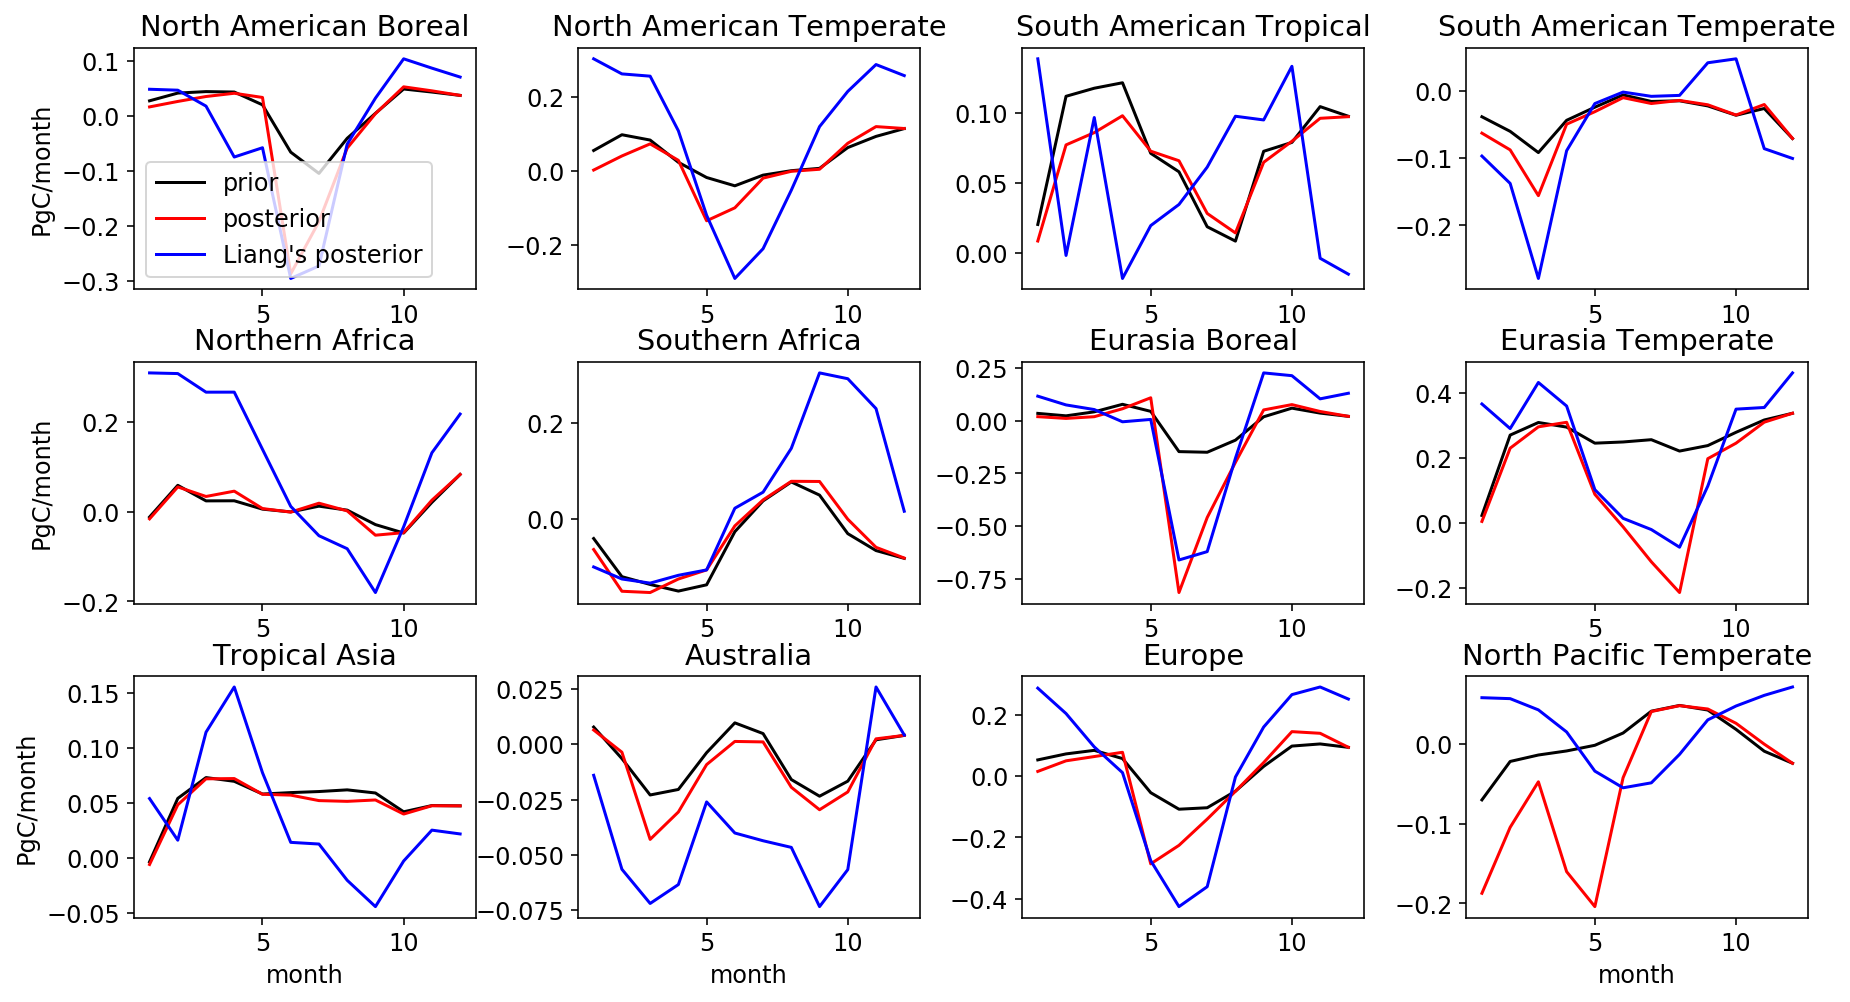

In [18]:
fig, axs = plt.subplots(3,4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(12):
    x = range(1,13)

    # before
    y = TC_monthly_regional_before[:,i]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    # after
    y = TC_monthly_regional_after[:,i]
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    axs[i].set_title(region_names[i])
    
    # Liang's posterior
    y = TC_monthly_regional_liang[:,i]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[4].set_ylabel('PgC/month')
axs[8].set_ylabel('PgC/month')
axs[0].legend()

axs[8].set_xlabel('month')
axs[9].set_xlabel('month')
axs[11].set_xlabel('month')

fig.savefig(fig_dir + 'inversion_regions1.png', dpi = 300)


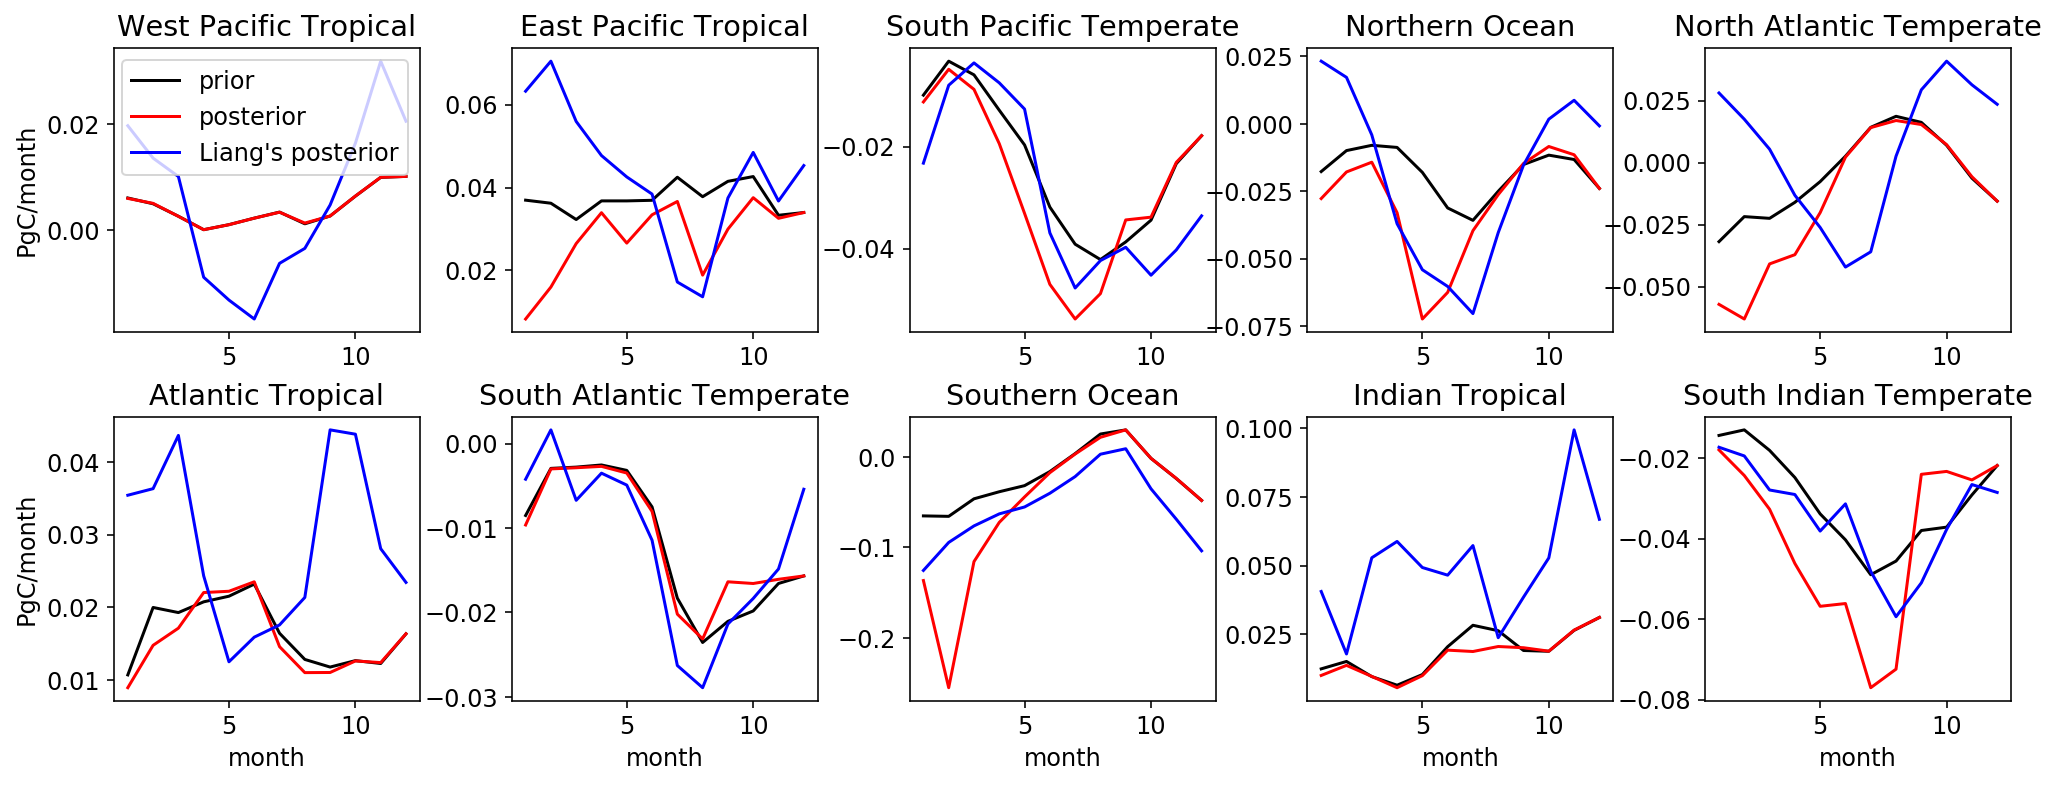

In [19]:
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(10):
    x = range(1,13)
    imonth = i+12

    # casa
    y = TC_monthly_regional_before[:,imonth]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = TC_monthly_regional_after[:,imonth]
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    axs[i].set_title(region_names[imonth])
    
    # Liang's posterior
    y = TC_monthly_regional_liang[:,imonth]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[5].set_ylabel('PgC/month')
axs[0].legend()

axs[5].set_xlabel('month')
axs[6].set_xlabel('month')
axs[7].set_xlabel('month')
axs[8].set_xlabel('month')
axs[9].set_xlabel('month')

fig.savefig(fig_dir + 'inversion_regions2.png', dpi = 300)


In [ ]:

# all fluxes used in simulations
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/monthly_emission.nc'
ds_monthly = xr.open_dataset(fname)
net_monthly = ds_monthly['ff'] + ds_monthly['fire'] + ds_monthly['ocean'] + ds_monthly['nte'] + ds_monthly['casa_bio']
casa_monthly = ds_monthly['casa_bio']


In [ ]:
# multiply this scale map to bio flux
# plot updates during lag window
fig, axes = plt.subplots(1,2, figsize=[15, 5], 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0})


net_monthly[0,:,:].plot(ax = axes[0], cmap = 'RdBu_r', vmax = 8e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.8})
#axes[0].set_title(long_name_of_month(assim_month - lag_window + i + 1), loc='left')
axes[0].set_title('net flux', loc='right')
axes[0].coastlines()
axes[0].gridlines(linestyle = '--')

casa_monthly[0,:,:].plot(ax = axes[1], cmap = 'RdBu_r', vmax = 8e9,
                    add_labels = False,
                    cbar_kwargs={'shrink': 0.8})
axes[1].set_title('bio flux', loc='right')
axes[1].coastlines()
axes[1].gridlines(linestyle = '--')


#fig.savefig(mod_dir  + 'flux_scaling.' + short_name_of_month(assim_month) + '.update.png', dpi = 300)

